# Cross-correlation analysis - example mouse dataset

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load results

In [2]:
result_path = r'M:/analysis/Axel_Bisi/results'
mouse_id = 'AB123'
file_name = '{}_xcorr_df.parquet'.format(mouse_id)
path_to_file = os.path.join(result_path, mouse_id, 'whisker_0', 'xcorr_analysis', file_name)

In [3]:
xcorr_df = pd.read_parquet(path_to_file)

In [4]:
print(len(xcorr_df)) # # Roa

210222


In [5]:
xcorr_df.columns

Index(['source_id', 'target_id', 'source_ccf', 'target_ccf',
       'source_ccf_parent', 'target_ccf_parent', 'source_fr', 'target_fr',
       'cch', 'bin_size_ms', 'jittered_cch', 'corrected_cch', 'flank_sd',
       'significant', 'lag_index', 'cch_peak_value', 'int_type'],
      dtype='object')

In [6]:
xcorr_df.source_ccf.unique()


array(['PO', 'VPL', 'LD', 'TH', 'SSp-bfd-D5-6a', 'SSp-bfd-D5-5',
       'SSp-bfd5', 'SSp-bfd4', 'SSp-bfd-C5-4', 'SSp-bfd-C5-2/3', 'CP',
       'MOs6a', 'MOs5', 'MOs2/3', 'AON', 'OLF', 'PIR', 'ORBl2/3', 'ORBl5',
       'ORBl6a', 'AId6a'], dtype=object)

In [7]:
xcorr_df['source_area'] = xcorr_df.apply(lambda x: x['source_ccf'] if not any(char.isdigit() for char in x['source_ccf']) else x['source_ccf_parent'], axis=1)
xcorr_df['target_area'] = xcorr_df.apply(lambda x: x['source_ccf'] if not any(char.isdigit() for char in x['source_ccf']) else x['source_ccf_parent'], axis=1)
xcorr_df['source_area'] = xcorr_df.apply(lambda x: 'SSp-bfd' if 'SSp-bfd' in x['source_area'] else x['source_area'], axis=1)
xcorr_df['target_area'] = xcorr_df.apply(lambda x: 'SSp-bfd' if 'SSp-bfd' in x['target_area'] else x['target_area'], axis=1)

In [8]:
xcorr_df.source_area.unique()


array(['PO', 'VPL', 'LD', 'TH', 'SSp-bfd', 'CP', 'MOs', 'AON', 'OLF',
       'PIR', 'ORBl', 'AId'], dtype=object)

In [9]:
xcorr_df['area_pairs'] = xcorr_df.apply(lambda x: 'within' if x['source_area']==x['target_area'] else 'across', axis=1)


In [10]:
xcorr_df[xcorr_df.significant==True]['area_pairs'].value_counts()

area_pairs
within    51
Name: count, dtype: int64

# Overview of significant correlations

NameError: name 'proportion_data' is not defined

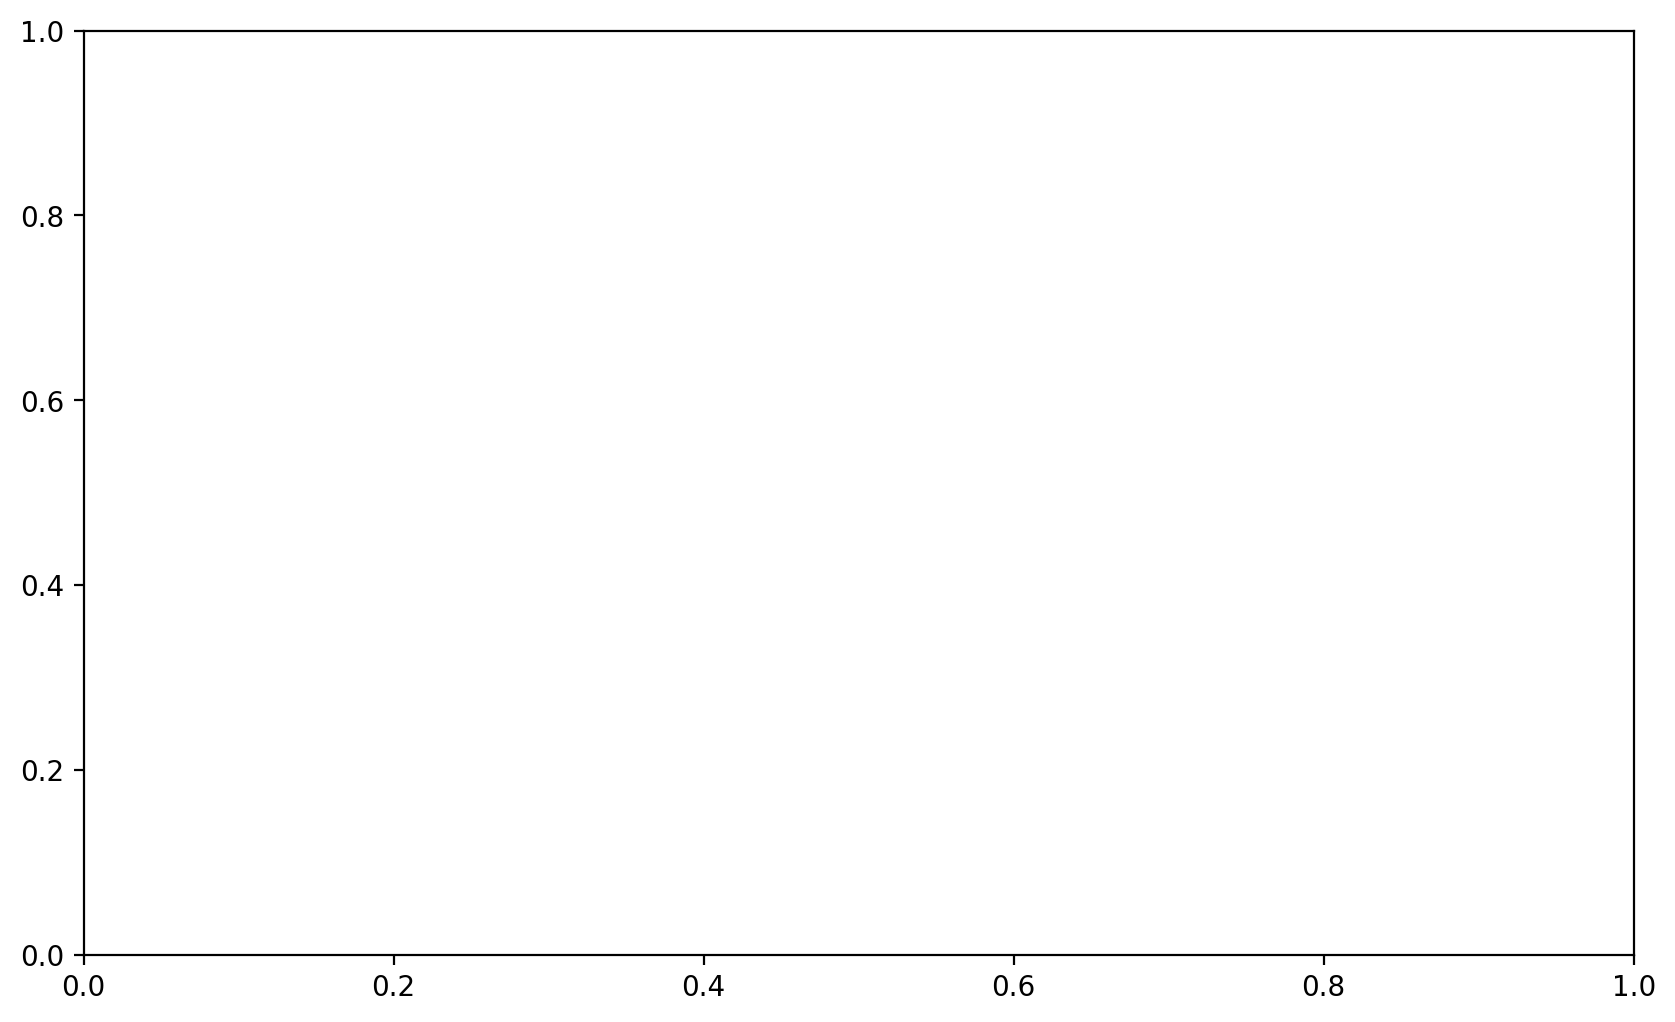

In [11]:
prop_sig_df = (
    xcorr_df.groupby('source_area')['significant']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'significant_count', 'count': 'total_count'})
)
prop_sig_df['proportion'] = prop_sig_df['significant_count'] / prop_sig_df['total_count'] * 100

# Bar plot
fig, ax = plt.subplots(1,1, figsize=(10, 6), dpi=200)
sns.barplot(x=prop_sig_df.index, y=proportion_data['proportion'], color='skyblue')
ax.set_ylabel('Proportion of significant interactions [%]', fontsize=15)
ax.set_xlabel('Source area', fontsize=15)
fig.tight_layout()
plt.show()

In [ ]:
prop_sig_df

# Histogram of lags
**No, make sense aggregating over mice.**

In [ ]:
xcorr_df_sig = xcorr_df[xcorr_df['significant']==True]
xcorr_df_sig.columns

# Unit-wise connectivity matrix

In [ ]:
def compute_connectivity_matrix(interaction_df: pd.DataFrame) -> np.ndarray:
    """
    Computes the connectivity matrix and significant connectivity matrix.
    
    Parameters:
    - interaction_df: DataFrame containing interaction data, including source, target, peak values, and significance.
    - unit_ids: List of unique unit IDs.
    
    Returns:
    - connectivity_matrix: Matrix containing all interaction peak values.
    - significant_connectivity_matrix: Matrix containing only significant interaction peak values.
    - id_to_index: Mapping from unit ID to matrix index.
    """
    # Create empty connectivity matrices
    n_units = interaction_df['source_id'].nunique()
    connectivity_matrix = np.full((n_units, n_units), np.nan)
    significant_connectivity_matrix = np.full((n_units, n_units), np.nan)

    # Create mapping from unit ID to matrix index
    id_to_index = {unit_id: i for i, unit_id in enumerate(unit_ids)}

    # Fill connectivity matrix with all interactions
    for _, row in interaction_df.iterrows():
        source_idx = id_to_index[row['source_id']]
        target_idx = id_to_index[row['target_id']]
        connectivity_matrix[source_idx, target_idx] = row['cch_peak_value']

    # Fill significant interactions connectivity matrix
    significant_interactions = interaction_df[interaction_df['significant']]
    for _, row in significant_interactions.iterrows():
        source_idx = id_to_index[row['source_id']]
        target_idx = id_to_index[row['target_id']]
        significant_connectivity_matrix[source_idx, target_idx] = row['cch_peak_value']
    
    return connectivity_matrix, significant_connectivity_matrix, id_to_index


#### Select some areas to make the plot smaller and visible

In [ ]:
xcorr_df_sub = xcorr_df[xcorr_df['source_area'].isin(['PO','SSp-bfd','MOs','VPL'])]
xcorr_df_sub = xcorr_df_sub.reset_index()
con_mat, sig_con_mat, id_to_index = compute_connectivity_matrix(xcorr_df_sub)

In [ ]:
plt.matshow(sig_con_mat)

In [ ]:
def generate_area_to_index(unit_area_df: pd.DataFrame) -> dict:
    """
    Generates a dictionary mapping areas to the list of unit indices for those areas.
    
    Parameters:
    - unit_area_df: DataFrame containing unit IDs and their corresponding brain areas.
    
    Returns:
    - area_to_index: Dictionary where keys are areas, and values are lists of unit indices.
    """
    # Initialize the dictionary
    area_to_index = {}

    # Iterate through the DataFrame and populate the dictionary
    for idx, row in unit_area_df.iterrows():
        unit_id = row['source_id']
        area = row['source_area']
        
        # If the area is not already in the dictionary, create an empty list for it
        if area not in area_to_index:
            area_to_index[area] = []
        
        # Append the index of the unit_id to the corresponding area
        area_to_index[area].append(unit_id)
    
    return area_to_index

# Generate the area_to_index dictionary
unit_area_df = xcorr_df[['source_id','source_area']]
area_to_index = generate_area_to_index(unit_area_df)

In [ ]:
def plot_connectivity_matrix(connectivity_matrix: np.ndarray,
                             area_to_index: dict,
                             folder_name: str) -> None:
    """
    Plots the connectivity matrix with areas properly labeled.
    
    Parameters:
    - connectivity_matrix: The matrix with connectivity values.
    - area_to_index: A dictionary mapping areas to lists of unit indices.
    - folder_name: The directory where the plot will be saved.
    """
    # Create sorted list of indices
    sorted_indices = []
    for area in sorted(area_to_index.keys()):
        sorted_indices.extend(area_to_index[area])

    # Reorder the connectivity matrix according to sorted indices
    sorted_matrix = connectivity_matrix[sorted_indices, :][:, sorted_indices]

    # Create the plot
    plt.figure(figsize=(10, 9))

    # Create the main heatmap
    im = plt.imshow(sorted_matrix, cmap='RdBu_r', aspect='equal', vmin=-100, vmax=200)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('CCH value', rotation=270, labelpad=15)

    # Add grid lines between areas
    current_pos = 0
    for area in sorted(area_to_index.keys()):
        current_pos += len(area_to_index[area])
        plt.axhline(y=current_pos - 0.5, color='gray', linestyle='-', linewidth=0.5)
        plt.axvline(x=current_pos - 0.5, color='gray', linestyle='-', linewidth=0.5)

    # Add area labels
    area_positions = []
    current_pos = 0
    for area in sorted(area_to_index.keys()):
        area_size = len(area_to_index[area])
        middle = current_pos + area_size / 2
        area_positions.append(middle)
        current_pos += area_size
    
    plt.xticks(area_positions, sorted(area_to_index.keys()), rotation=45, ha='right')
    plt.yticks(area_positions, sorted(area_to_index.keys()))
    plt.xlabel('Source')
    plt.ylabel('Target')

    # Layout and save the plot
    plt.tight_layout()
    plots_dir = os.path.join(folder_name, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    plot_path = os.path.join(plots_dir, 'connectivity_matrix.png')
    
    #plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Connectivity matrix plot saved to: {plot_path}")

In [ ]:
    plot_connectivity_matrix(sig_con_mat, area_to_index, None)

In [ ]:
# Create matrix for visualization (source_area as rows, target_area as columns)
units = sorted(set(xcorr_df['source_id']).union(xcorr_df['target_id']))
unit_matrix = pd.DataFrame(index=units, columns=units, data=np.nan)

# Fill matrix with `strength` values for significant interactions
for _, row in xcorr_df[xcorr_df['significant']].iterrows():
    unit_matrix .loc[row['source_id'], row['target_id']] = row['cch_peak_value']
    unit_matrix .loc[row['target_id'], row['source_id']] = row['cch_peak_value']  # Assuming symmetry NO

# Define a colormap function based on the `direction`
def get_colormap(int_type):
    if int_type == 'excitatory':
        return 'Reds'
    elif int_type == 'inhibitory':
        return 'Purples'
    return None

# Mask for non-significant values (we'll keep them white)
sns.heatmap(
    unit_matrix, 
    mask=unit_matrix.isna(),  # Mask NaN values to keep them white
    cmap='gray',  # Default gray color for non-significant values
    cbar=True, 
    annot=True, 
    fmt='.1f', 
    linewidths=0.5, 
    square=True, 
    ax=ax
)

# Apply the dual colormap based on direction
for _, row in xcorr_df[xcorr_df['significant']].iterrows():
    cmap = get_colormap(row['int_type'])
    if cmap:
        # Get the location of the pair in the unit_matrix
        source_idx = units.index(row['source_id'])
        target_idx = units.index(row['target_id'])
        
        # Highlight each significant pair with its corresponding colormap
        ax.add_patch(plt.Rectangle(
            (source_idx, target_idx),  # Position of the interaction
            1, 1,  # Size of the square (each cell)
            color=cmap  # Apply the colormap
        ))

ax.set_title('Pairwise Significant Interactions')
ax.set_xlabel('Target unit')
ax.set_ylabel('Source unit')

plt.tight_layout()
plt.show()